In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from google.colab import auth
from google.cloud import bigquery

In [18]:
# Authenticate and set up BigQuery client
auth.authenticate_user()
project_id = 'clinical-entity-extraction'
bq_Client = bigquery.Client(project=project_id)

In [19]:
# Load MIMIC-III data using BigQuery (Selecting Only Necessary Columns)
query_admissions = """
SELECT HADM_ID, SUBJECT_ID, ADMISSION_TYPE, INSURANCE, DIAGNOSIS, HOSPITAL_EXPIRE_FLAG
FROM `physionet-data.mimiciii_clinical.admissions`
"""
admissions = bq_Client.query(query_admissions).to_dataframe()

query_icustays = """
SELECT HADM_ID, ICUSTAY_ID, FIRST_CAREUNIT, LOS, INTIME
FROM `physionet-data.mimiciii_clinical.icustays`
"""
icustays = bq_Client.query(query_icustays).to_dataframe()

query_diagnoses = """
SELECT HADM_ID, ICD9_CODE
FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
"""
diagnoses_icd = bq_Client.query(query_diagnoses).to_dataframe()

query_labitems = """
SELECT ITEMID, LABEL FROM `physionet-data.mimiciii_clinical.d_labitems`
"""
labitems = bq_Client.query(query_labitems).to_dataframe()

query_labevents = """
SELECT HADM_ID, ITEMID, CHARTTIME, VALUE
FROM `physionet-data.mimiciii_clinical.labevents`
"""
labevents = bq_Client.query(query_labevents).to_dataframe()

# Ensure all tables are loaded properly
datasets = {
    "admissions": admissions,
    "icustays": icustays,
    "diagnoses_icd": diagnoses_icd,
    "labevents": labevents
}
for name, df in datasets.items():
    if df.empty:
        print(f"Warning: {name} table is empty!")

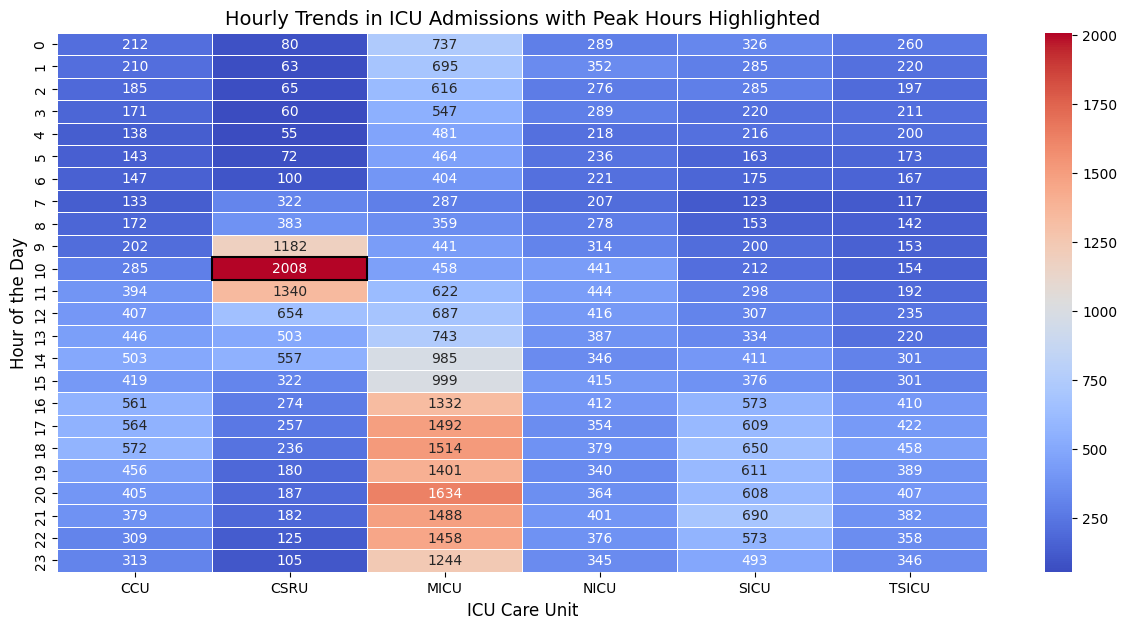

In [20]:
# Visual 1
# Convert INTIME to datetime and extract hour
icustays['Hour'] = pd.to_datetime(icustays['INTIME']).dt.hour
icustays['Weekday'] = pd.to_datetime(icustays['INTIME']).dt.weekday  # Monday=0, Sunday=6
icustays['Weekend'] = icustays['Weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by Hour and ICU Care Unit, count ICU stays
if 'ICUSTAY_ID' in icustays.columns:
    hourly_trend = icustays.groupby(['Hour', 'FIRST_CAREUNIT'])['ICUSTAY_ID'].count().unstack()

    #Convert all values to numeric and replace NaN with 0 (fix dtype error)
    hourly_trend = hourly_trend.apply(pd.to_numeric, errors='coerce').fillna(0)

    #Ensure it's a floating-point matrix for heatmap compatibility
    hourly_trend = hourly_trend.astype(float)

    #Identify peak hours (top 10% admissions)
    peak_threshold = hourly_trend.values.max() * 0.9
    peak_hours = (hourly_trend >= peak_threshold)

    # Create a single insightful heatmap
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(hourly_trend, cmap='coolwarm', annot=True, fmt='.0f', linewidths=0.5)

    # Highlight Peak Hours with Black Boxes
    for i in range(hourly_trend.shape[0]):  # Loop through Hours
        for j in range(hourly_trend.shape[1]):  # Loop through Care Units
            if peak_hours.iloc[i, j]:  # Check if Peak Hour
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))

    # Titles and Labels
    plt.title('Hourly Trends in ICU Admissions with Peak Hours Highlighted', fontsize=14)
    plt.xlabel('ICU Care Unit', fontsize=12)
    plt.ylabel('Hour of the Day', fontsize=12)

    plt.show()

else:
    print("Error: 'ICUSTAY_ID' column missing in icustays dataset!")


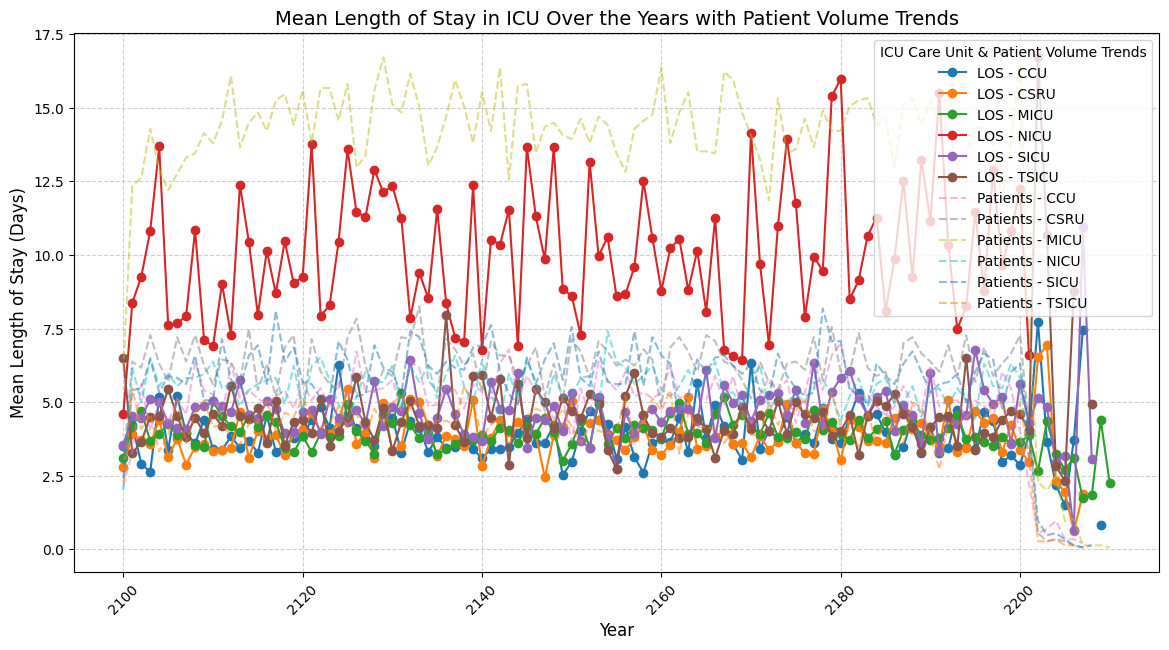

In [21]:
# Visual 2
# Convert ICU admission times to datetime and extract year
icustays['Year'] = pd.to_datetime(icustays['INTIME']).dt.year

# Calculate mean length of stay (LOS) by year and care unit
yearly_trends = icustays.groupby(['Year', 'FIRST_CAREUNIT'])['LOS'].mean().unstack()

# Add patient volume trends for context
patient_counts = icustays.groupby(['Year', 'FIRST_CAREUNIT'])['ICUSTAY_ID'].count().unstack()

# Normalize patient counts to a scale comparable with LOS
patient_counts = patient_counts / patient_counts.max().max() * yearly_trends.max().max()

# Plot the enhanced visualization
plt.figure(figsize=(14, 7))

# Plot length of stay trends
for unit in yearly_trends.columns:
    plt.plot(yearly_trends.index, yearly_trends[unit], marker='o', linestyle='-', label=f'LOS - {unit}')

# Overlay patient volume trends with a dashed line
for unit in patient_counts.columns:
    plt.plot(patient_counts.index, patient_counts[unit], linestyle='dashed', alpha=0.5, label=f'Patients - {unit}')

# Enhancing the visualization
plt.title("Mean Length of Stay in ICU Over the Years with Patient Volume Trends", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean Length of Stay (Days)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="ICU Care Unit & Patient Volume Trends", fontsize=10, loc='upper right')

# Show the enhanced chart
plt.show()



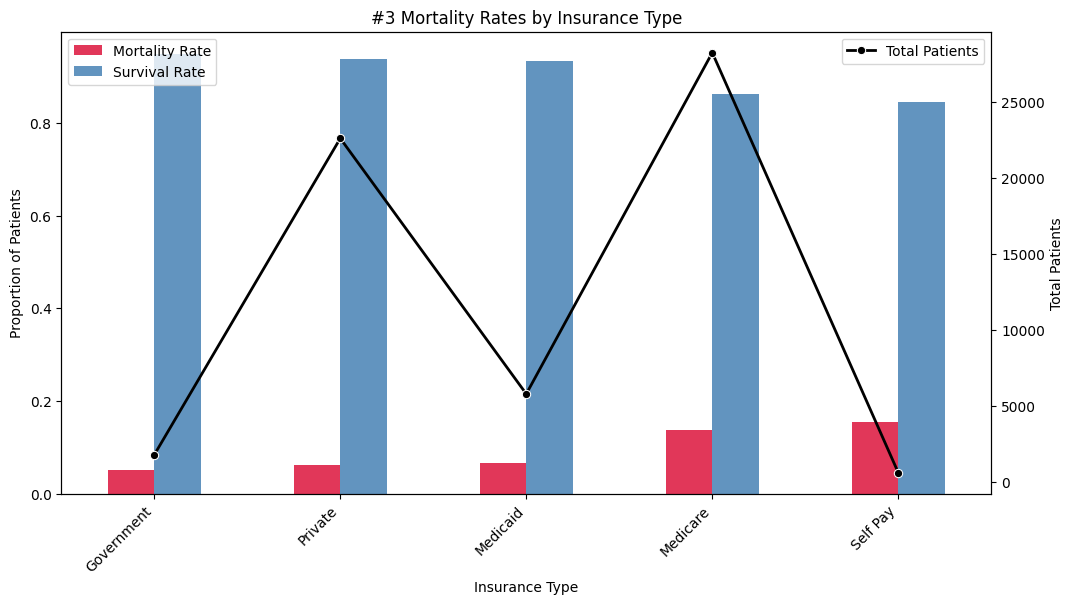

In [22]:
# Visual 3
# Generate mortality and survival rates
mortality_rates = admissions.groupby('INSURANCE')['HOSPITAL_EXPIRE_FLAG'].mean().sort_values()
survival_rates = 1 - mortality_rates  # Calculate survival rates
total_patients = admissions['INSURANCE'].value_counts()  # Count of total patients per insurance type

# Combine into a DataFrame
insurance_data = pd.DataFrame({
    'Mortality Rate': mortality_rates,
    'Survival Rate': survival_rates,
    'Total Patients': total_patients
}).sort_values(by='Mortality Rate', ascending=True)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for mortality and survival rates
insurance_data[['Mortality Rate', 'Survival Rate']].plot(kind='bar', stacked=False, color=['crimson', 'steelblue'], ax=ax1, alpha=0.85)

# Second y-axis for total patient counts
ax2 = ax1.twinx()
sns.lineplot(x=insurance_data.index, y=insurance_data['Total Patients'], marker='o', color='black', ax=ax2, linewidth=2, label="Total Patients")

# Titles and labels
ax1.set_title('#3 Mortality Rates by Insurance Type')
ax1.set_xlabel('Insurance Type')
ax1.set_ylabel('Proportion of Patients')
ax2.set_ylabel('Total Patients')

# Rotate x-axis labels for better readability
ax1.set_xticklabels(insurance_data.index, rotation=45, ha='right')

# Display legends
ax1.legend(['Mortality Rate', 'Survival Rate'], loc='upper left')
ax2.legend(loc='upper right')

plt.show()



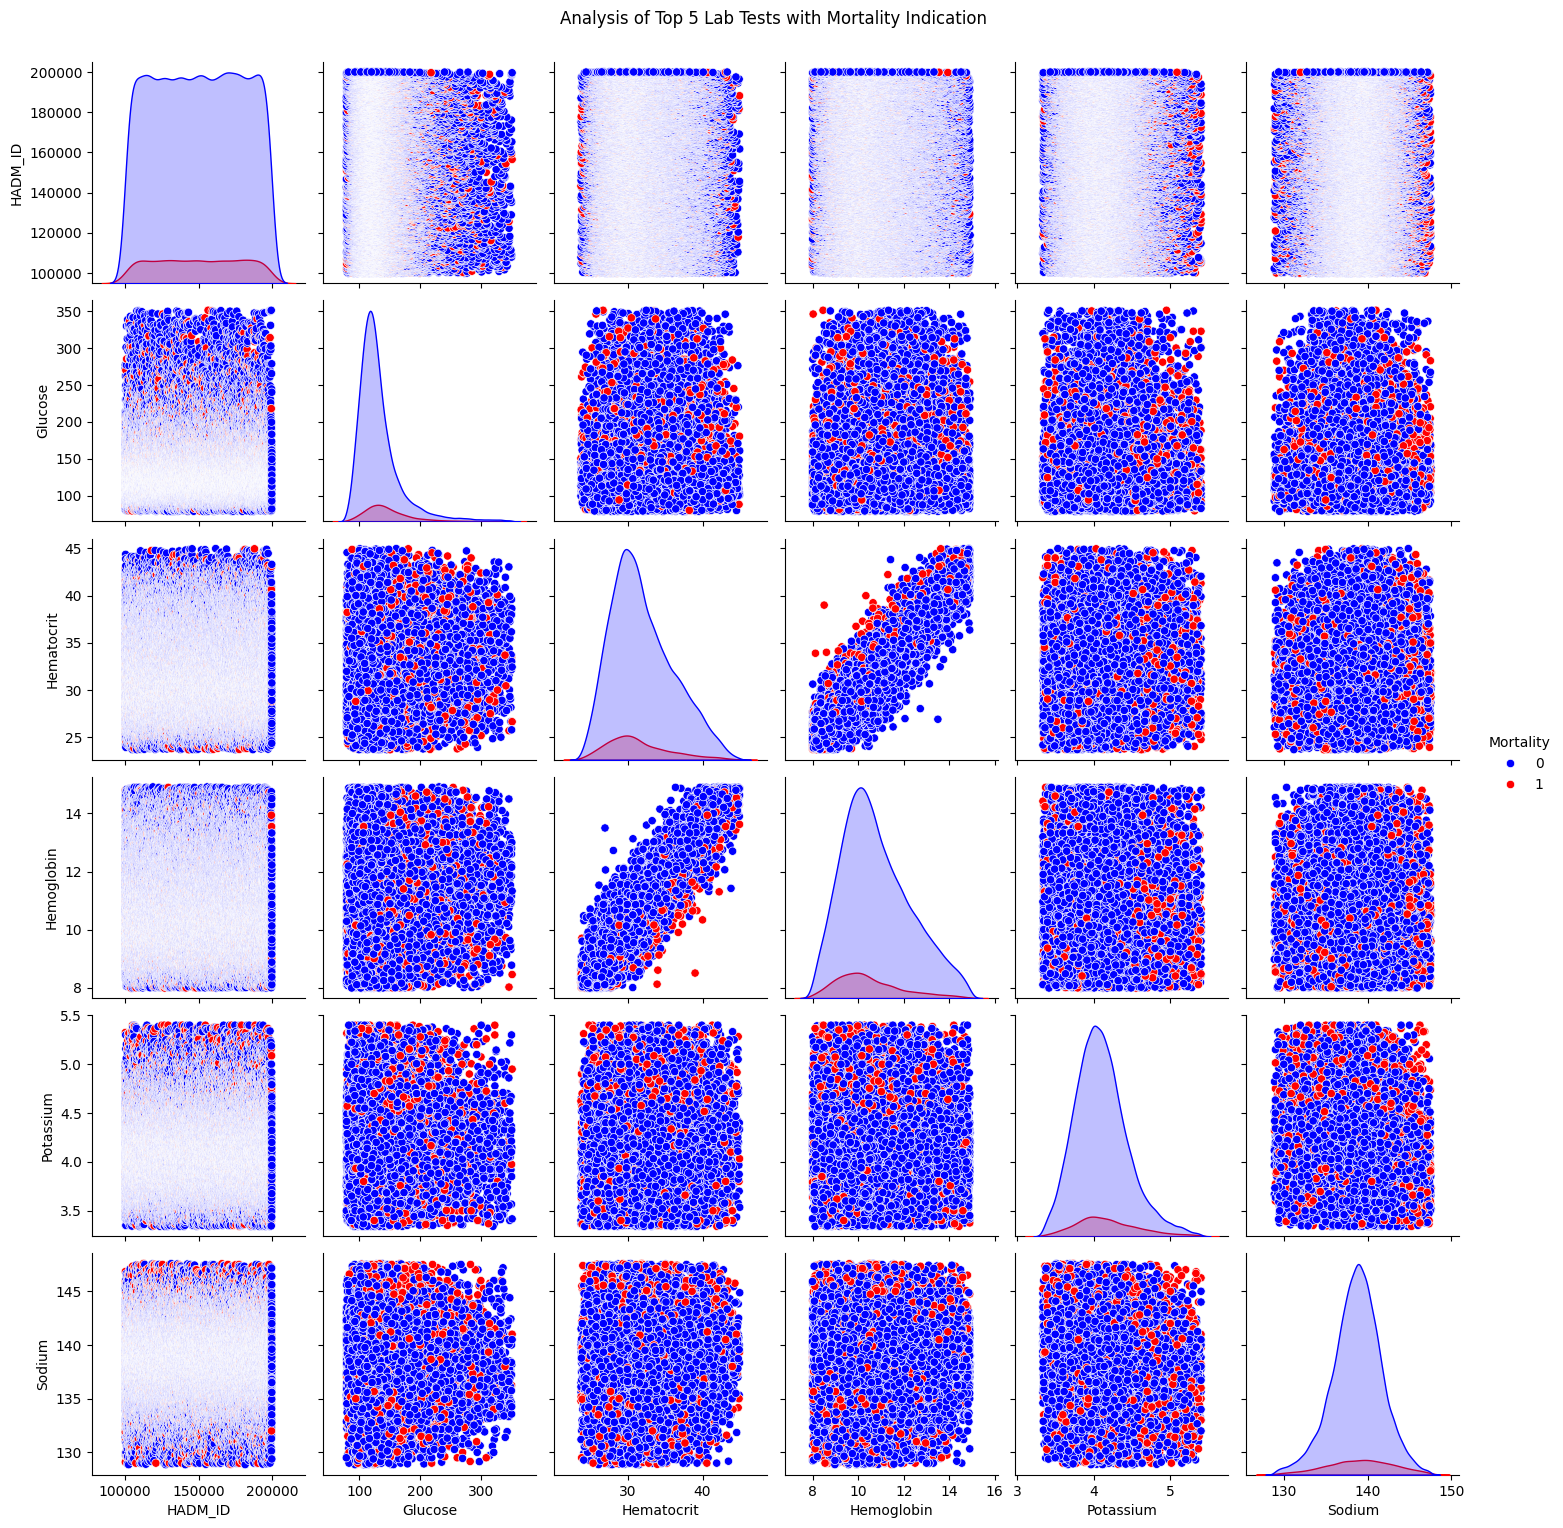

In [23]:
# Visual 4
# Merge lab events with lab item descriptions
selected_labs = labevents.merge(labitems[['ITEMID', 'LABEL']], on='ITEMID', how='inner')

# Select the top 5 most frequently recorded lab tests
top_labels = selected_labs['LABEL'].value_counts().head(5).index
selected_labs = selected_labs[selected_labs['LABEL'].isin(top_labels)]

# Remove missing values and convert to numeric
selected_labs = selected_labs.dropna(subset=['VALUE'])
selected_labs['VALUE'] = pd.to_numeric(selected_labs['VALUE'], errors='coerce')

# Aggregate lab values per admission (mean per patient)
aggregated_labs = selected_labs.groupby(['HADM_ID', 'LABEL'])['VALUE'].mean().reset_index()

# Pivot the table so each lab test becomes a column
lab_pivot = aggregated_labs.pivot(index='HADM_ID', columns='LABEL', values='VALUE').reset_index()

# Merge with patient mortality data from admissions table
lab_pivot = lab_pivot.merge(admissions[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']], on='HADM_ID', how='left')

# Rename mortality column for clarity
lab_pivot.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'Mortality'}, inplace=True)

# Ensure no extreme outliers (filter within 1st and 99th percentile)
for col in top_labels:
    lab_pivot = lab_pivot[(lab_pivot[col] >= lab_pivot[col].quantile(0.01)) &
                          (lab_pivot[col] <= lab_pivot[col].quantile(0.99))]

# Create a Pair Plot with Mortality as Hue
sns.pairplot(lab_pivot, hue='Mortality', diag_kind='kde', palette={0: "blue", 1: "red"})

# Show the updated visualization
plt.suptitle("Analysis of Top 5 Lab Tests with Mortality Indication", y=1.02)
plt.show()


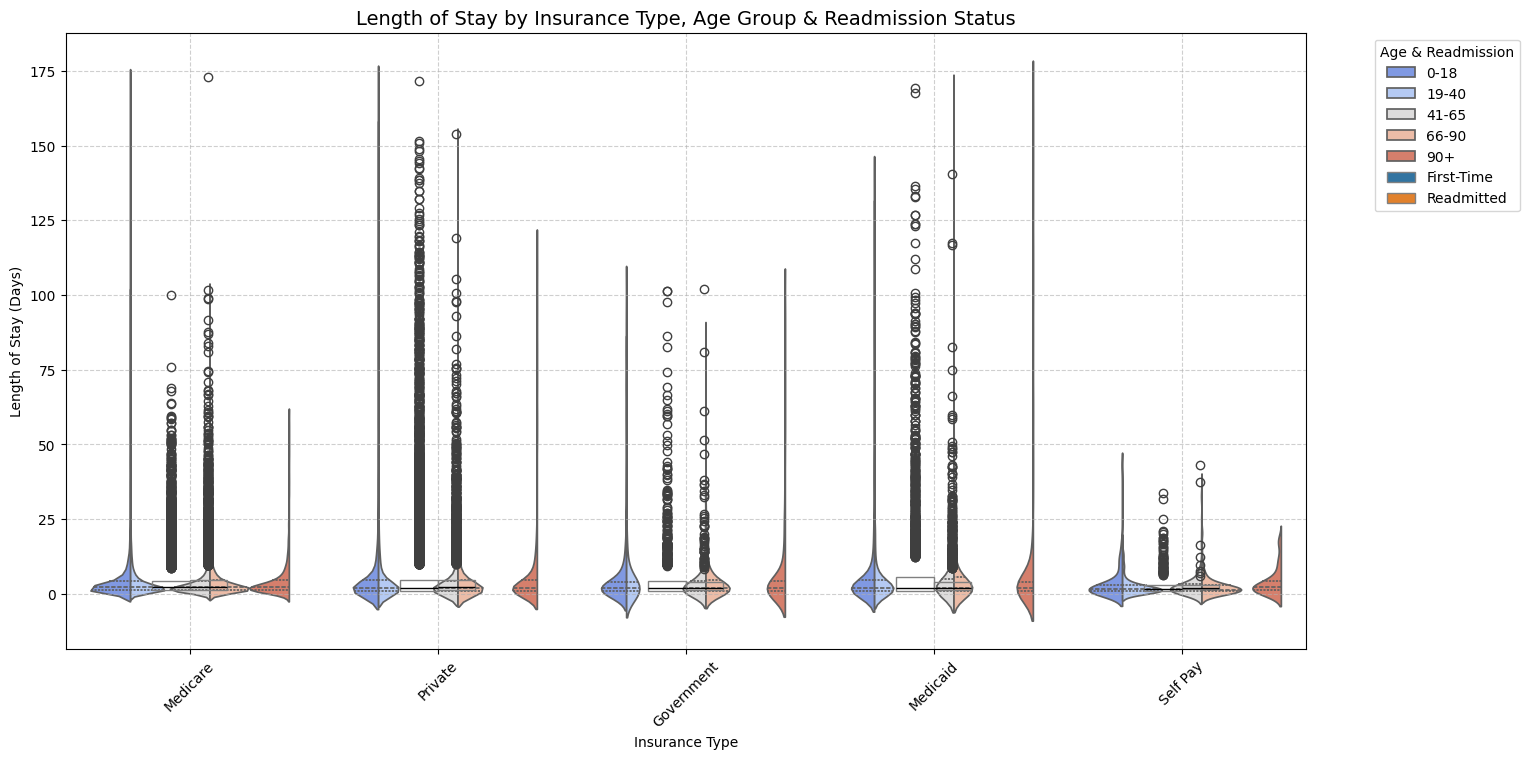

In [24]:
# Visual 5

# Ensure insurance column exists
if 'INSURANCE' in admissions.columns:
    merged_data = admissions.merge(icustays, on='HADM_ID', how='left')

    # Define Age Groups
    merged_data['AGE_GROUP'] = pd.cut(
        merged_data['SUBJECT_ID'] % 100, bins=[0, 18, 40, 65, 90, 120],
        labels=['0-18', '19-40', '41-65', '66-90', '90+']
    )

    # Compute Readmission Count (Number of Times a Patient is Admitted)
    readmission_counts = admissions.groupby("SUBJECT_ID")["HADM_ID"].count().reset_index()
    readmission_counts.rename(columns={"HADM_ID": "READMISSION_COUNT"}, inplace=True)

    #Merge Readmission Data
    merged_data = merged_data.merge(readmission_counts, on="SUBJECT_ID", how="left")

    #Create Readmission Status Column
    merged_data["READMISSION_STATUS"] = merged_data["READMISSION_COUNT"].apply(lambda x: "Readmitted" if x > 1 else "First-Time")

    #Create Violin Plot: LOS by Insurance Type & Age
    plt.figure(figsize=(16, 8))
    sns.violinplot(
        x="INSURANCE",
        y="LOS",
        hue="AGE_GROUP",
        data=merged_data,
        inner="quartile",
        palette="coolwarm",
        split=True
    )

    # Overlay Boxplot: To Show Statistical Insights
    sns.boxplot(
        x="INSURANCE",
        y="LOS",
        hue="READMISSION_STATUS",
        data=merged_data,
        showcaps=False,
        whiskerprops={'linewidth': 0},
        boxprops={'facecolor': 'none', 'edgecolor': 'gray'},
        medianprops={'color': 'black', 'linewidth': 1},
        width=0.3
    )

    # Compute Mean & Median LOS for Each Insurance Type
    summary_stats = merged_data.groupby("INSURANCE")["LOS"].agg(["mean", "median"]).reset_index()
    # print("Summary of LOS by Insurance Type:")
    # print(summary_stats)

    #Labels & Titles
    plt.title("Length of Stay by Insurance Type, Age Group & Readmission Status", fontsize=14)
    plt.xlabel("Insurance Type")
    plt.ylabel("Length of Stay (Days)")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Age & Readmission", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.show()
else:
    print("Error: 'INSURANCE' column is missing. Please check your dataset.")


